In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from robo_limb_ml.models.fk_lstm import FK_LSTM
from robo_limb_ml.models.fk_mlp import FK_MLP
from robo_limb_ml.models.fk_rnn import FK_RNN
from robo_limb_ml.models.fk_seq2seq import FK_SEQ2SEQ


In [ ]:
input_size = 6
hidden_size = 512
num_layers = 3
batch_size = 512
output_size = 4
seq_len = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = ""
model = FK_LSTM(input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_size=batch_size,
                output_size=output_size,
                device=device,
                batch_first=True).to(device=device)
model.load_state_dict(torch.load(model_path))
model.h0 = torch.zeros(3, 1, 512).to(device=device)
model.c0 = torch.zeros(3, 1, 512).to(device=device)

In [6]:
test_df = pd.read_csv("../../ml_data/test_data.csv").dropna()
test_df


,time_begin,time_begin_traj,theta_x,theta_y,vel_x,vel_y,X_throttle,Y_throttle
0,0.348,0.348,-1.50,3.70,0.0,0.000000,0.0,0.0
1,0.409,0.409,-1.50,3.07,0.0,-10.327869,0.0,0.0
2,0.471,0.471,-1.50,3.07,0.0,0.000000,0.0,0.0
3,0.532,0.532,-1.50,3.07,0.0,0.000000,0.0,0.0
4,0.594,0.594,-1.50,3.07,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
31261,1172.517,121.126,-22.03,-37.59,0.0,0.000000,-2.0,10.0
31262,1172.589,121.198,-22.03,-37.59,0.0,0.000000,-2.0,10.0
31263,1172.661,121.270,-22.03,-37.06,0.0,7.361111,-2.0,10.0
31264,1172.733,121.342,-22.03,-37.06,0.0,0.000000,-2.0,10.0


In [22]:
delta_t = test_df["time_begin"].diff()
delta_t = delta_t.value_counts()
delta_t

time_begin
0.067     4007
0.068     3424
0.069     2842
0.066     1588
0.070     1276
          ... 
0.200        1
20.524       1
0.202        1
0.205        1
0.246        1
Name: count, Length: 641, dtype: int64

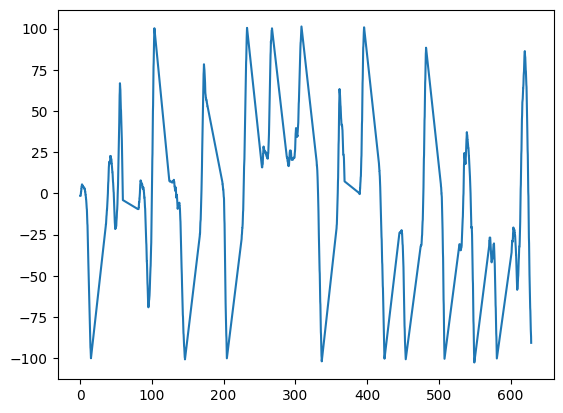

In [32]:
plt.plot(test_df["time_begin"][:3000], test_df["theta_x"][:3000])

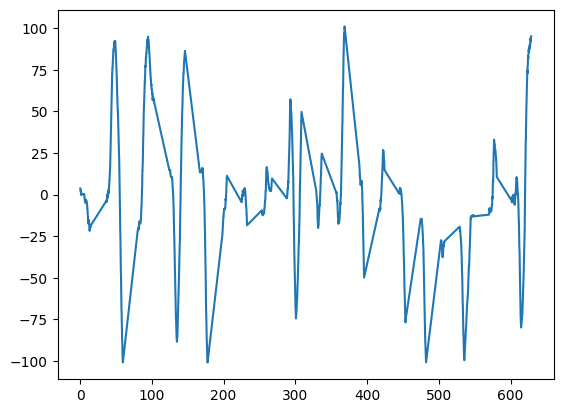

In [33]:
plt.plot(test_df["time_begin"][:3000], test_df["theta_y"][:3000])

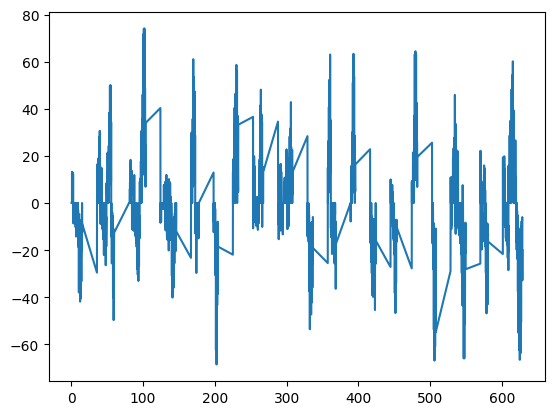

In [34]:
plt.plot(test_df["time_begin"][:3000], test_df["vel_x"][:3000])

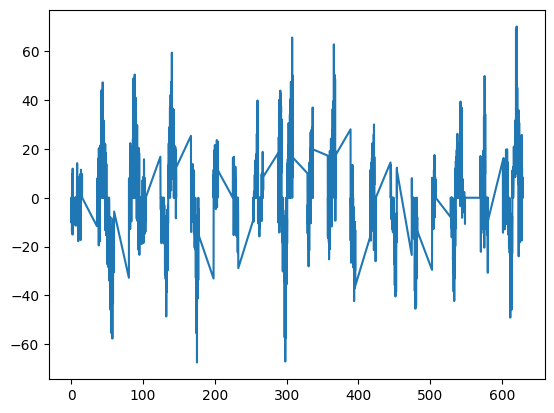

In [35]:
plt.plot(test_df["time_begin"][:3000], test_df["vel_y"][:3000])

In [36]:
test_df.columns

Index(['time_begin', 'time_begin_traj', 'theta_x', 'theta_y', 'vel_x', 'vel_y',
       'X_throttle', 'Y_throttle'],
      dtype='object')

In [ ]:
init_data = test_df.drop(columns=["vel_x", "vel_y"]).iloc[:seq_len]
init_data = torch.tensor(init_data.values, dtype=torch.float32).to(device=device)
test_tensor = torch.tensor(test_df.values, dtype=torch.float32).to(device=device)
outputs = torch.zeros(test_df.shape).to(device=device)
outputs[:seq_len] = init_data.copy()

for i in range(seq_len, test_df.shape[0]):
    data = outputs[i - seq_len:i]
    time_begin, time_begin_traj, theta_x, theta_y, vel_x, vel_y, X_throttle, Y_throttle = test_tensor[i - 1]
    delta_states = model(data.unsqueeze(0)).squeeze(0)
    time_begin_1, time_begin_traj_1, _, _, _, _, X_throttle_1, Y_throttle_1 = test_tensor[i]
    pred_theta_x, pred_theta_y, pred_vel_x, pred_vel_y = delta_states[0] + theta_x, delta_states[1] + theta_y, delta_states[2] + vel_x, delta_states[3] + vel_y
    outputs[i] = torch.tensor([time_begin_1, time_begin_traj_1, pred_theta_x, pred_theta_y, pred_vel_x, pred_vel_y, X_throttle_1, Y_throttle_1]).to(device=device)

In [ ]:
from torcheval.metrics import R2Score
metric = R2Score()
metric.update(outputs[seq_len:, 2:4], test_tensor[seq_len:, 2:4])
r2_score = metric.compute()
print(r2_score)